# EDA

This EDA is narrowed to the local scope within 5 km from the point of interest

## 1. Load cleaned data

In [40]:
# Standard imports
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, TypeVar, Generic
import time
import re

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Third party imports
from geopy.exc import  GeocoderTimedOut, GeocoderUnavailable
from geopy.geocoders import Nominatim
from haversine import haversine
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns

# Local imports
from _csv_utils import data_timeplace, DataPathCleaningManager


In [41]:
data_path_manager = DataPathCleaningManager(data_timeplace)

df_olx = data_path_manager.load_df(domain="olx", is_cleaned=True)
df_otodom = data_path_manager.load_df(domain="otodom", is_cleaned=True)

### 1.1 OLX

In [42]:
df_olx

,link,title,price,summary_description,ownership,floor_level,is_furnished,building_type,square_meters,number_of_rooms,rent,voivodeship,city,street
0,https://www.olx.pl/d/oferta/kawalerka-tychy-os...,Kawalerka Tychy oś M,1500.0,OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...,private,3,False,apartment_building,26,1,400.0,Śląskie,Zawada,Moniuszki 1/16


In [43]:
df_olx.columns

Index(['link', 'title', 'price', 'summary_description', 'ownership',
       'floor_level', 'is_furnished', 'building_type', 'square_meters',
       'number_of_rooms', 'rent', 'voivodeship', 'city', 'street'],
      dtype='object')

### 1.2 otodom

In [44]:
df_otodom.sample(5)

listing  \
                                                  link   
820  https://www.otodom.pl/pl/oferta/golonog-po-rem...   
478  https://www.otodom.pl/pl/oferta/ciche-mieszkan...   
706  https://www.otodom.pl/pl/oferta/mieszkanie-w-c...   
3    https://www.otodom.pl/pl/oferta/kawalerka-os-p...   
278  https://www.otodom.pl/pl/oferta/sliczne-mieszk...   

                                                        \
                                                 title   
820        Gołonóg Po Remoncie z Wyposażeniem od 01.12   
478                 Ciche mieszkanie w ścisłym centrum   
706      Mieszkanie w centrum miasta, 2 pokoje, widok!   
3                          Kawalerka os. Paderewskiego   
278  Śliczne mieszkanie w kultowej Podkowie / Koszutka   

                                                                      pricing  \
                                   summary_description remote_service   price   
820  Do wynajęcia od 1 grudnia 2023roku  2 pokojowe...           <NA>  1800.0   
478  Na wynajem mieszkanie wykończone w stylu lofto...    unspecified  1800.0   
706  Oferta wynajmu mieszkania na Koszutce w Katowi...           <NA>  1590.0   
3    Oferujemy do wynajęcia przytulną kawalerkę zlo...    unspecified  1400.0   
278  Oferujemy do wynajęcia 2-pokojowe mieszkanie p...           <NA>  2000.0   

                               \
      rent total_rent deposit   
820    NaN     1800.0     NaN   
478  870.0     2670.0  3000.0   
706  570.0     2160.0  3599.0   
3      1.0     1401.0  1400.0   
278    NaN     2000.0  3000.0   

                                              location  \
                                      complete_address   
820  Cieszkowskiego, Gołonóg, Gołonóg Północny, Dąb...   
478  ul. Juliusza Słowackiego, Śródmieście, Katowic...   
706                        Koszutka, Katowice, śląskie   
3    ul. Graniczna, Osiedle Paderewskiego-Muchowiec...   
278    ul. Stefana Okrzei, Koszutka, Katowice, śląskie   

                               ... building_material              \
                       street  ...          silicate large_panel   
820            Cieszkowskiego  ...             False       False   
478  ul. Juliusza Słowackiego  ...             False       False   
706                  Koszutka  ...             False       False   
3               ul. Graniczna  ...             False       False   
278        ul. Stefana Okrzei  ...             False       False   

                        additional_information                          \
    reinforced_concrete         no_information duplex air_conditioning   
820               False                  False  False            False   
478               False                  False  False             True   
706               False                   True  False            False   
3                 False                   True  False            False   
278               False                   True  False            False   

                                                             
    separate_kitchen basement utility_room non_smokers_only  
820             True    False        False             True  
478            False    False        False            False  
706            False    False        False            False  
3              False    False        False            False  
278            False    False        False            False  

[5 rows x 73 columns]

In [45]:
df_otodom.columns

MultiIndex([(               'listing',                           'link'),
            (               'listing',                          'title'),
            (               'listing',            'summary_description'),
            (               'listing',                 'remote_service'),
            (               'pricing',                          'price'),
            (               'pricing',                           'rent'),
            (               'pricing',                     'total_rent'),
            (               'pricing',                        'deposit'),
            (              'location',               'complete_address'),
            (              'location',                         'street'),
            (              'location',                           'city'),
            (              'location',                    'voivodeship'),
            (                  'size',                  'square_meters'),
            (                  'size',

### 1.3 Narrowed data to the very local market (5km)

In [46]:
def combine_olx_otodom(df_olx: pd.DataFrame = df_olx, df_otodom: pd.DataFrame = df_otodom):

    # Step 1: Create a mapping
    column_mapping = {
        'link': ('listing', 'link'),
        'title': ('listing', 'title'),
        'price': ('pricing', 'price'),
        'rent': ('pricing', 'rent'),
        'summary_description': ('listing', 'summary_description'),
        'ownership': ('legal_and_availability', 'ownership'),
        'floor_level': ('size', 'floor'),
        'is_furnished': ('equipment', 'furniture'),
        'building_type': ('type_and_year', 'building_type'),
        'square_meters': ('size', 'square_meters'),
        'number_of_rooms': ('size', 'number_of_rooms'),
        'rent': ('pricing', 'rent'),
        'voivodeship': ('location', 'voivodeship'),
        'city': ('location', 'city'),
        'street': ('location', 'street')
    }

    # Step 2: Modify df_olx to have a MultiIndex
    df_olx.columns = pd.MultiIndex.from_tuples([column_mapping[col] if col in column_mapping else (col, '') for col in df_olx.columns])

    # Step 3: Fill missing columns in df_olx
    # Identify missing columns
    missing_columns = set(df_otodom.columns) - set(df_olx.columns)

    # Fill missing columns with NaN or False
    for col in missing_columns:
        if col in [('equipment', 'furniture'),]:  # Add other boolean columns if any
            df_olx[col] = False
        else:
            df_olx[col] = np.nan

    # Reorder df_olx columns to match df_otodom
    df_olx = df_olx.reindex(columns=df_otodom.columns)

    # Add total_rent column
    df_olx[('pricing', 'total_rent')] = df_olx[('pricing', 'price')].add(df_olx[('pricing', 'rent')], fill_value=0)

    # Create complete_address column
    df_olx[('location', 'complete_address')] = df_olx.apply(
    lambda row: ', '.join(
        filter(None, [row[('location', 'street')], row[('location', 'city')], row[('location', 'voivodeship')]])
    ),
    axis=1
)
    pd.set_option('display.max_rows', None)
    df_olx.iloc[0]

    # Fill NaNs
    # Replacing NaN with False
    columns_to_fill_false = [
        ('size', 'attic'),
        ('amenities', 'elevator'),
        ('amenities', 'parking_space'),
        ('equipment', 'no_information'),
        ('equipment', 'stove'),
        ('equipment', 'fridge'),
        ('equipment', 'oven'),
        ('equipment', 'washing_machine'),
        ('equipment', 'TV'),
        ('equipment', 'dishwasher'),
        ('media_types', 'internet'),
        ('media_types', 'telephone'),
        ('media_types', 'cable_TV'),
        ('heating', 'electric'),
        ('heating', 'gas'),
        ('heating', 'other'),
        ('heating', 'boiler_room'),
        ('heating', 'district'),
        ('heating', 'tile_stove'),
        ('security', 'intercom_or_video_intercom'),
        ('security', 'anti_burglary_doors_or_windows'),
        ('security', 'monitoring_or_security'),
        ('security', 'anti_burglary_roller_blinds'),
        ('security', 'alarm_system'),
        ('security', 'enclosed_area'),
        ('windows', 'aluminum'),
        ('windows', 'wooden'),
        ('windows', 'plastic'),
        ('building_material', 'concrete'),
        ('building_material', 'aerated_concrete'),
        ('building_material', 'brick'),
        ('building_material', 'wood'),
        ('building_material', 'other'),
        ('building_material', 'lightweight_aggregate'),
        ('building_material', 'hollow_brick'),
        ('building_material', 'silicate'),
        ('building_material', 'large_panel'),
        ('building_material', 'reinforced_concrete'),
        ('additional_information', 'duplex'),
        ('additional_information', 'air_conditioning'),
        ('additional_information', 'separate_kitchen'),
        ('additional_information', 'basement'),
        ('additional_information', 'utility_room'),
        ('additional_information', 'non_smokers_only'),
    ] 
    for col in columns_to_fill_false:
        df_olx[col] = df_olx[col].fillna(False)

    # Replacing NaN with True
    columns_to_fill_true = [
        ('media_types', 'no_information'),
        ('heating', 'no_information'),
        ('security', 'no_information'),
        ('windows', 'no_information'),
        ('building_material', 'no_information'),
        ('additional_information', 'no_information'),
    ]

    for col in columns_to_fill_true:
        df_olx[col] = df_olx[col].fillna(True)

    # Step 5: Set the same dtypes for df_olx as in df_otodom
    for column in df_otodom.columns:
        if column in df_olx.columns:
            df_olx[column] = df_olx[column].astype(df_otodom[column].dtype)


    # Step 6: Append df_olx to df_otodom
    combined_df = pd.concat([df_otodom, df_olx], ignore_index=True)

    # Step 7: Add deposit_ratio column
    combined_df.loc[:, ("pricing", "deposit_ratio")] = np.where(
        combined_df["pricing"]["total_rent"] != 0,
        (combined_df["pricing"]["deposit"] / combined_df["pricing"]["total_rent"]).round(2),
        np.nan  # or 0, depending on your preference for default value
    )

    # Step 8: Add total price per square meter column
    combined_df.loc[:, ("pricing", "total_rent_sqm")] = (combined_df['pricing']['total_rent'] / combined_df['size']['square_meters']).replace([np.inf, -np.inf], np.nan)

    # Step 9: Reorder columns

    columns = combined_df.columns.tolist()

    new_and_old_columns = [
        (8, columns.index(("pricing", "deposit_ratio"))),
        (7, columns.index(("pricing", "total_rent_sqm"))),
    ]

    for new, old in new_and_old_columns:
        columns.insert(new, columns.pop(old))

    combined_df = combined_df[columns]

    return combined_df

combined_df = combine_olx_otodom(df_olx, df_otodom)

def filter_row(row):
    try:
        city = row['location']['city']
        building_type = row['type_and_year']['building_type'] if pd.notna(row['type_and_year'].get('building_type')) else False
        build_year = row['type_and_year']['build_year'] if pd.notna(row['type_and_year'].get('build_year')) else False
        return city in ["będziński", "Zawada", "Siewierz", "tarnogórski", "Piekary Śląskie", "zawierciański", "Siemianowice Śląskie"] \
        and building_type in ["block_of_flats", "apartment_building"] \
        and build_year <= 1970
    except KeyError:
        return False

narrowed_df = combined_df[combined_df.apply(filter_row, axis=1)].copy()
narrowed_df.tail(3)

listing  \
                                                   link   
1072  https://www.otodom.pl/pl/oferta/komfortowa-dob...   
1096  https://www.otodom.pl/pl/oferta/mieszkanie-do-...   
1105  https://www.olx.pl/d/oferta/kawalerka-tychy-os...   

                                                    \
                                             title   
1072        Komfortowa dobrze wyposażona kawalerka   
1096  Mieszkanie do wynajęcia Apartamenty Lasowice   
1105                          Kawalerka Tychy oś M   

                                                                        \
                                    summary_description remote_service   
1072  Komfortowe, wyremontowane i wyposażone we wszy...           <NA>   
1096  Do wynajęcia mieszkanie kompletnie wyposażone ...           <NA>   
1105  OpisWynajmę kawalerkę na ul Moniuszki 1/16 .na...           <NA>   

     pricing                                                         ...  \
       price   rent total_rent total_rent_sqm deposit deposit_ratio  ...   
1072  1200.0  780.0     1980.0      63.870968  2000.0          1.01  ...   
1096  2000.0    NaN     2000.0           50.0  2000.0          1.00  ...   
1105  1500.0  400.0     1900.0      73.076923     NaN           NaN  ...   

     building_material                                 additional_information  \
              silicate large_panel reinforced_concrete         no_information   
1072             False        True               False                  False   
1096             False       False               False                  False   
1105             False       False               False                   True   

                                                                     \
     duplex air_conditioning separate_kitchen basement utility_room   
1072  False            False            False     True        False   
1096  False            False            False    False        False   
1105  False            False            False    False        False   

                       
     non_smokers_only  
1072            False  
1096             True  
1105            False  

[3 rows x 75 columns]

In [47]:
len(narrowed_df)

43

In [48]:
narrowed_df.dtypes.to_dict()

{('listing', 'link'): string[python],
 ('listing', 'title'): string[python],
 ('listing', 'summary_description'): string[python],
 ('listing', 'remote_service'): string[python],
 ('pricing', 'price'): dtype('float64'),
 ('pricing', 'rent'): dtype('float64'),
 ('pricing', 'total_rent'): dtype('float64'),
 ('pricing', 'total_rent_sqm'): Float64Dtype(),
 ('pricing', 'deposit'): dtype('float64'),
 ('pricing', 'deposit_ratio'): dtype('float64'),
 ('location', 'complete_address'): string[python],
 ('location', 'street'): string[python],
 ('location', 'city'): string[python],
 ('location', 'voivodeship'): string[python],
 ('size', 'square_meters'): Int64Dtype(),
 ('size', 'number_of_rooms'): Int64Dtype(),
 ('size', 'floor'): Int64Dtype(),
 ('size', 'attic'): dtype('bool'),
 ('size', 'building_floors'): Int64Dtype(),
 ('legal_and_availability', 'available_from'): string[python],
 ('legal_and_availability', 'completion'): string[python],
 ('legal_and_availability', 'ownership'): string[python],

In [49]:
narrowed_df[('listing', 'link')].duplicated().sum()

0

## 2. EDA

### 2.1 Numerical data

#### A. Furnished and unfurnished

In [50]:
narrowed_df.describe()

pricing                                                       \
             price        rent   total_rent total_rent_sqm      deposit   
count    43.000000   30.000000    43.000000           43.0    34.000000   
mean   1656.744186  496.900000  2003.418605      42.896639  3017.647059   
std     616.463497  263.520509   660.296010      11.478599   974.048281   
min     600.000000    1.000000   900.000000           18.0  1300.000000   
25%    1200.000000  305.000000  1600.000000      36.350294  2500.000000   
50%    1600.000000  498.000000  1901.000000      43.173913  3000.000000   
75%    1875.000000  707.500000  2495.000000       50.46875  3550.000000   
max    3800.000000  990.000000  4570.000000      73.076923  5500.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count     34.000000          43.0            43.0      41.0            38.0   
mean       1.565588     48.418605        2.209302   2.02439        3.894737   
std        0.534059     15.552113        0.832613  2.043132         2.05057   
min        0.670000          25.0             1.0       0.0             1.0   
25%        1.030000          38.0             2.0       1.0             3.0   
50%        1.505000          46.0             2.0       2.0             4.0   
75%        1.997500          52.5             3.0       3.0             4.0   
max        2.730000         104.0             4.0      10.0            10.0   

      type_and_year  
         build_year  
count           4.0  
mean         1960.0  
std            20.0  
min          1930.0  
25%          1960.0  
50%          1970.0  
75%          1970.0  
max          1970.0

In [51]:
len(narrowed_df)

43

In [52]:
furnished_offers = narrowed_df[
    narrowed_df["equipment"]["furniture"] == True
]
non_furnished_offers = narrowed_df[
    narrowed_df["equipment"]["furniture"] == False
]

#### B. Furnished

In [53]:
furnished_offers.describe()

pricing                                                       \
             price        rent   total_rent total_rent_sqm      deposit   
count    28.000000   22.000000    28.000000           28.0    25.000000   
mean   1671.071429  480.409091  2048.535714      44.302336  2904.000000   
std     593.035751  238.677240   669.412871      10.305154   926.678657   
min     800.000000    1.000000  1100.000000      18.461538  1300.000000   
25%    1275.000000  305.750000  1682.500000      36.668297  2500.000000   
50%    1550.000000  498.000000  1983.000000      45.772575  2900.000000   
75%    1850.000000  687.500000  2492.500000      50.958227  3000.000000   
max    3800.000000  800.000000  4570.000000      65.526316  5000.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count     25.000000          28.0            28.0      27.0            26.0   
mean       1.468000     47.571429            2.25  1.814815        3.961538   
std        0.519005     15.459454        0.844371  2.057576        1.969381   
min        0.670000          25.0             1.0       0.0             1.0   
25%        1.000000          38.0             2.0       0.0             3.0   
50%        1.380000          46.0             2.0       2.0             4.0   
75%        1.920000          50.0             3.0       3.0             4.0   
max        2.730000         104.0             4.0      10.0            10.0   

      type_and_year  
         build_year  
count      3.000000  
mean    1956.666667  
std       23.094011  
min     1930.000000  
25%     1950.000000  
50%     1970.000000  
75%     1970.000000  
max     1970.000000

#### C. Unfurnished

In [54]:
non_furnished_offers.describe()

pricing                                                       \
             price        rent   total_rent total_rent_sqm      deposit   
count    15.000000    8.000000    15.000000           15.0     9.000000   
mean   1630.000000  542.250000  1919.200000      40.272671  3333.333333   
std     678.706753  337.026811   657.330119      13.384274  1088.577053   
min     600.000000    1.000000   900.000000           18.0  1500.000000   
25%    1050.000000  315.000000  1555.000000      34.618056  3000.000000   
50%    1600.000000  555.000000  1867.000000      40.140845  3300.000000   
75%    1900.000000  787.750000  2425.000000      44.745321  3800.000000   
max    2900.000000  990.000000  2900.000000      73.076923  5500.000000   

                             size                                            \
      deposit_ratio square_meters number_of_rooms     floor building_floors   
count      9.000000          15.0            15.0      14.0            12.0   
mean       1.836667          50.0        2.133333  2.428571            3.75   
std        0.505964     16.142225        0.833809  2.027286        2.301185   
min        0.940000          25.0             1.0       1.0             1.0   
25%        1.500000          41.0             2.0       1.0            2.75   
50%        1.990000          48.0             2.0       1.5             4.0   
75%        2.250000          63.5             2.5      3.75             4.0   
max        2.500000          75.0             4.0       8.0            10.0   

      type_and_year  
         build_year  
count           1.0  
mean         1970.0  
std             NaN  
min          1970.0  
25%          1970.0  
50%          1970.0  
75%          1970.0  
max          1970.0

### 2.2 Total rent

In [55]:
aesthetics_plots = {
	'title_size': 16,
    'y_and_x_label_size': 12,
	'fontweight': 'bold',
	'label_color': "#435672",
    "palette": "viridis",
    "figsize": {
        "multiplot": (15, 10),  # (width, height) in inches
        "singleplot": (8, 6),
        },
    }

def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(data_series: pd.Series, title: str, kde_setting: bool, bin: int, x_ticks_number: int, x_ticks_rotation: bool):
    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])

    cmap = plt.get_cmap('viridis')
    color = cmap(0.5)  # Using a single color, you can adjust this as needed

    sns.histplot(data_series, ax=ax, kde=kde_setting, bins=bin, color=color)
    set_plot_aesthetics(ax, title)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(data_series)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, weight='bold', color=aesthetics_plots['label_color'], xytext=(0, 2),
                        textcoords='offset points')

    plt.tight_layout()
    plt.show()

In [56]:
def advanced_statistical_analysis(df: pd.DataFrame = narrowed_df):
    price_data = df['pricing']['total_rent']

    # Central Tendency Measures
    mean_price = price_data.mean()
    median_price = price_data.median()
    mode_price = price_data.mode()[0]

    # Variability Measures
    std_dev_price = price_data.std()
    variance_price = price_data.var()
    range_price = price_data.max() - price_data.min()
    iqr_price = np.percentile(price_data, 75) - np.percentile(price_data, 25)

    # Skewness and Kurtosis
    skewness_price = price_data.skew()
    kurtosis_price = price_data.kurtosis()

    # Quantile Analysis
    quantiles_price = price_data.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

    # Outlier Detection: Using the 1.5*IQR rule
    lower_bound = np.percentile(price_data, 25) - 1.5 * iqr_price
    upper_bound = np.percentile(price_data, 75) + 1.5 * iqr_price
    outliers_upper = price_data[(price_data >= upper_bound)].count()
    outliers_lower = price_data[(price_data <= lower_bound)].count()
    outlier_total = outliers_upper + outliers_lower

    advanced_statistics = {
        "Mean": mean_price.round(2),
        "Median": median_price,
        "Standard Deviation": std_dev_price.round(2),
        "Mode": mode_price,
        "Variance": variance_price.round(2),
        "Range": range_price,
        "Interquartile Range (IQR)": iqr_price,
        "Skewness": skewness_price.round(2),
        "Kurtosis": kurtosis_price.round(2),
        "Quantiles": quantiles_price,
        "Outlier Lower Bound": lower_bound,
        "Outlier Upper Bound": upper_bound,
        "Number of Lower Bound": outliers_upper,
        "Number of Upper Bound": outliers_lower,
        "Number of Outliers": outlier_total,
        "Total Number of Listings": price_data.count(),
        "Ratio of Outliers to Total Listings": str((outlier_total / price_data.count()).round(2) * 100)+ "%",
    }

    print("Total Price, Advanced Statistics:")
    return advanced_statistics

advanced_statistical_analysis(narrowed_df)

Total Price, Advanced Statistics:


{'Mean': 2003.42,
 'Median': 1901.0,
 'Standard Deviation': 660.3,
 'Mode': 1600.0,
 'Variance': 435990.82,
 'Range': 3670.0,
 'Interquartile Range (IQR)': 895.0,
 'Skewness': 1.32,
 'Kurtosis': 4.08,
 'Quantiles': 0.25    1600.0
 0.50    1901.0
 0.75    2495.0
 0.90    2690.0
 0.95    2886.0
 0.99    3868.6
 Name: total_rent, dtype: float64,
 'Outlier Lower Bound': 257.5,
 'Outlier Upper Bound': 3837.5,
 'Number of Lower Bound': 1,
 'Number of Upper Bound': 0,
 'Number of Outliers': 1,
 'Total Number of Listings': 43,
 'Ratio of Outliers to Total Listings': '2.0%'}

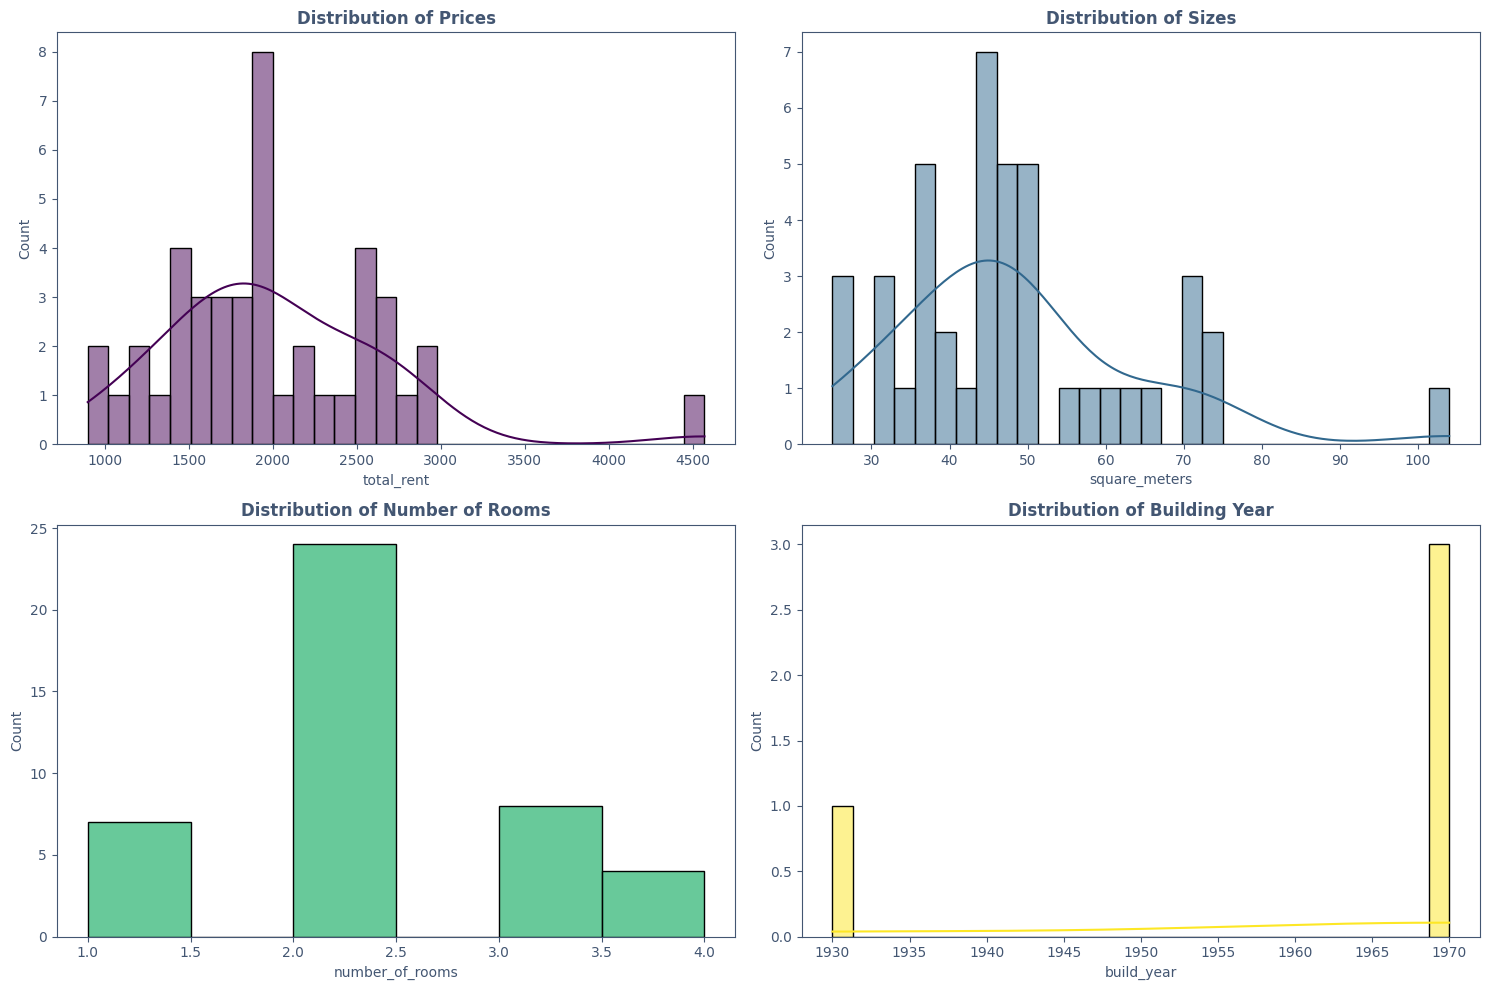

In [57]:
def plot_distributions(narrowed_df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=aesthetics_plots['figsize']['multiplot'])

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))

    titles = ['Distribution of Prices', 'Distribution of Sizes', 'Distribution of Number of Rooms', 'Distribution of Building Year']
    data_columns = ['pricing.total_rent', 'size.square_meters', 'size.number_of_rooms', 'type_and_year.build_year']
    kde_settings = [True, True, False, True]
    bins = [30, 30, 6, 30]

    for ax, title, color, data_column, kde_setting, bin in zip(axes.flat, titles, colors, data_columns, kde_settings, bins):
        sns.histplot(narrowed_df[data_column.split('.')[0]][data_column.split('.')[1]].astype('float'), ax=ax, kde=kde_setting, bins=bin, color=color)
        set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distributions(narrowed_df)

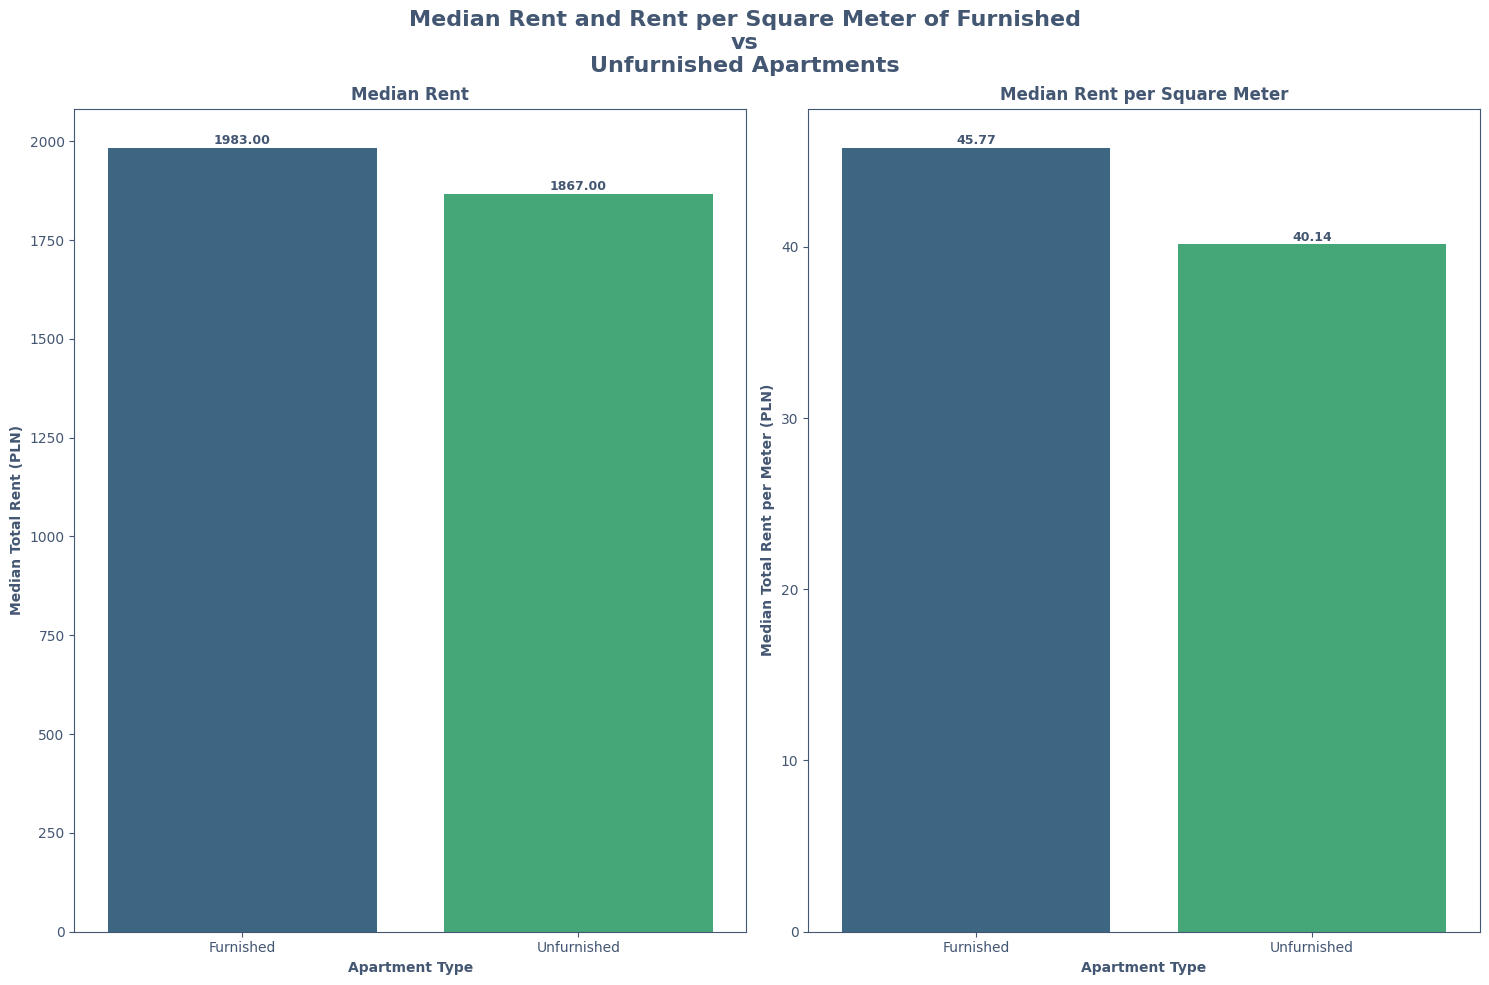

Median Differences:
Furnished vs Unfurnished: 116.0 PLN
Furnished vs Unfurnished per Square Meter: 6.0 PLN


In [58]:
def set_plot_aesthetics(ax, title=None, xlabel=None, ylabel=None, title_color="#435672", tick_color="#435672", fontweight='bold'):
    if title:
        ax.set_title(title, color=title_color, fontweight=fontweight)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight=fontweight)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight=fontweight)
    ax.tick_params(colors=tick_color, which='both')  # For both major and minor ticks
    ax.yaxis.label.set_color(tick_color)  # Y-axis label color
    ax.xaxis.label.set_color(tick_color)  # X-axis label color
    for spine in ax.spines.values():  # Spine color
        spine.set_edgecolor(tick_color)

def plot_distribution(narrowed_df: pd.DataFrame):

    # No information about furniture delete
    # refactor

    # Calculate medians
    median_furnished = narrowed_df[narrowed_df['equipment']['furniture']]['pricing']['total_rent'].median()
    median_unfurnished = narrowed_df[~narrowed_df['equipment']['furniture']]['pricing']['total_rent'].median()
    
    median_furnished_sqm = (narrowed_df[narrowed_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()
    median_unfurnished_sqm = (narrowed_df[~narrowed_df['equipment']['furniture']]['pricing']['total_rent_sqm']).median()

    # Prepare data for plotting
    median_data_furnishing = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent': [median_furnished, median_unfurnished]
    })

    median_data_square_meter = pd.DataFrame({
        'Furniture': ['Furnished', 'Unfurnished'],
        'Median Rent per Square Meter': [median_furnished_sqm, median_unfurnished_sqm]
    })

    title = 'Median Rent and Rent per Square Meter of Furnished\nvs\nUnfurnished Apartments'

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=aesthetics_plots['figsize']['multiplot'])

    # Plotting Median Rent
    sns.barplot(x='Furniture', y='Median Rent', data=median_data_furnishing, ax=ax1, palette='viridis')

    # Plotting Median Rent per Square Meter
    sns.barplot(x='Furniture', y='Median Rent per Square Meter', data=median_data_square_meter, ax=ax2, palette='viridis')

    for ax in [ax1, ax2]:
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], fontweight='bold',
                        xytext=(0, 5),
                        textcoords='offset points')
            
    # Apply aesthetics to each subplot
    set_plot_aesthetics(ax1, title='Median Rent', xlabel='Apartment Type', ylabel='Median Total Rent (PLN)')
    set_plot_aesthetics(ax2, title='Median Rent per Square Meter', xlabel='Apartment Type', ylabel='Median Total Rent per Meter (PLN)')

    # Set the main title for the figure
    fig.suptitle(title, color="#435672", fontsize=aesthetics_plots['title_size'], fontweight='bold')


    plt.tight_layout()
    plt.show()

    print(f"Median Differences:")
    print(f"Furnished vs Unfurnished: {abs(median_furnished - median_unfurnished)} PLN")
    print(f"Furnished vs Unfurnished per Square Meter: {(abs(median_furnished_sqm - median_unfurnished_sqm)).round()} PLN")

plot_distribution(narrowed_df)

In [59]:
def show_categorical_data_percentage_distribution(
        df: pd.DataFrame, 
        categorical_column: Tuple[str, str], 
        distribution_column: Tuple[str, str], 
        title: str,
        x_ticks_number: int = 10,
        y_ticks_number: int = 8,
        x_ticks_rotation: bool = True,
        y_ticks_rotation: bool = True,
    ):
    
    # Create a subset DataFrame with only the required columns
    plot_data = df[[categorical_column, distribution_column]].dropna()

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 7))

    # Get unique building types from the categorical column
    building_types = plot_data[categorical_column].unique()

    # Generate a list of colors, one for each building type
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f'] + ["#FF9F66"]

    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.

    # Plot each building type's histogram
    for building_type, color in zip(building_types, my_palette):
        # Select the rows where the building type matches and is not null
        subset = plot_data[plot_data[categorical_column] == building_type]
        sns.histplot(subset[distribution_column], kde=False, color=color, label=building_type, ax=ax)

    
    # Add some formatting and titles
    x_axis_title = distribution_column[1].replace('_', ' ')

    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel(x_axis_title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Frequency', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    legend = plt.legend(title=x_axis_title)
    plt.setp(legend.get_title(), fontsize='large', color=aesthetics_plots['label_color'], weight='bold')
    plt.setp(legend.get_texts(), color=aesthetics_plots['label_color'])

    # Customize x-axis ticks
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=x_ticks_number))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=y_ticks_number))

    if x_ticks_rotation:
        ax.xaxis.set_major_locator(ticker.FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
    if y_ticks_rotation:
        ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
        ax.set_yticklabels(ax.get_yticklabels(), rotation=45)

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add annotations for each bar
    for p in ax.patches:
        # Calculate the percentage of the total
        percentage = (p.get_height() / len(df)) * 100
        # Place the annotation above the bar
        if percentage > 0:
            ax.annotate(f"{percentage:.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='bottom', fontsize=10, color=aesthetics_plots['label_color'], xytext=(0, 8),
                        textcoords='offset points')

    # Show the plot
    plt.show()

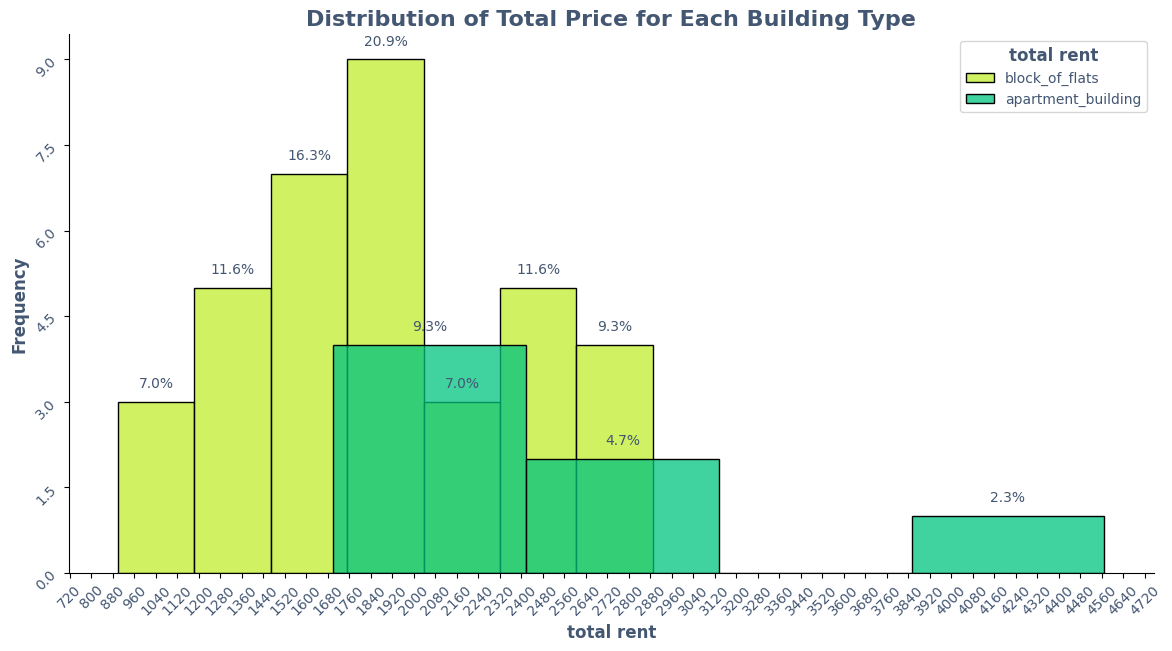

In [60]:
show_categorical_data_percentage_distribution(
    narrowed_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent'),
    'Distribution of Total Price for Each Building Type',
    x_ticks_number= 60,
    x_ticks_rotation= True
    )

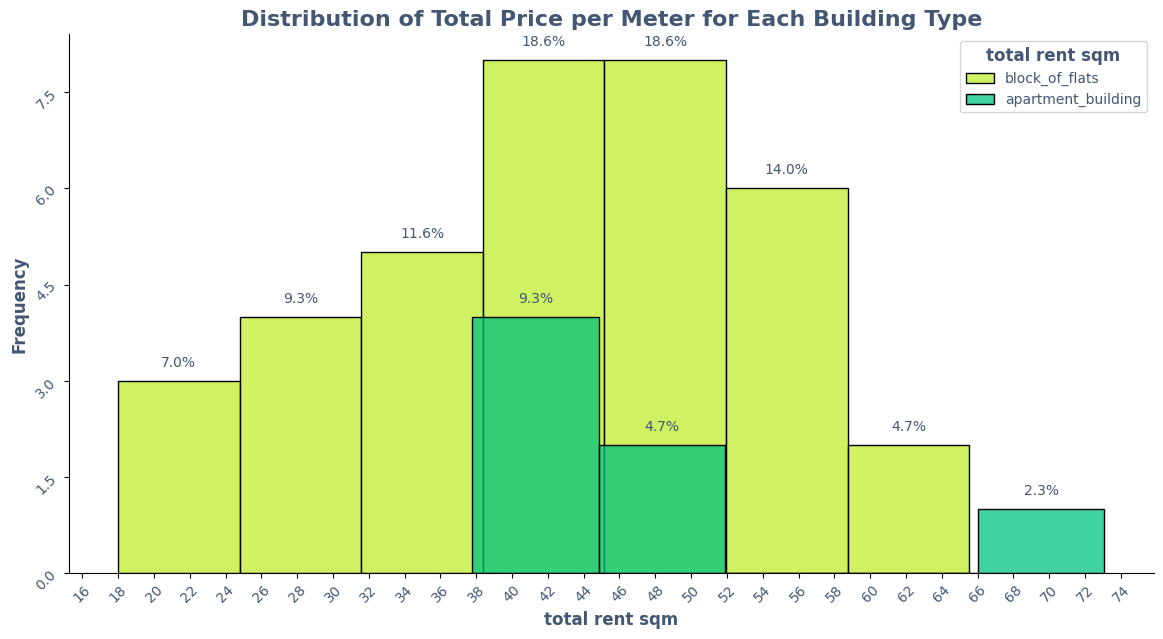

In [61]:
show_categorical_data_percentage_distribution(
    narrowed_df,  
    ('type_and_year', 'building_type'),
    ('pricing', 'total_rent_sqm'),
    'Distribution of Total Price per Meter for Each Building Type',
    x_ticks_number= 40,
    x_ticks_rotation= True
    )

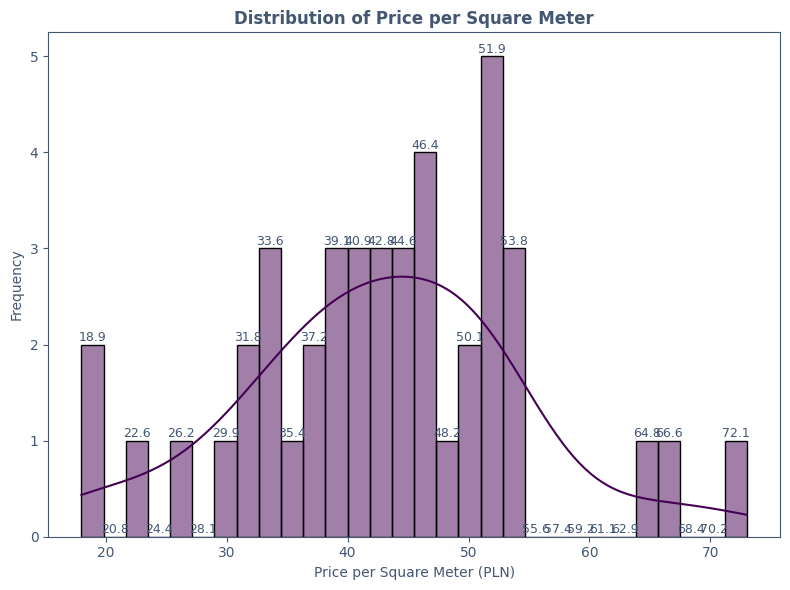

In [62]:
def plot_distribution(narrowed_df: pd.DataFrame):

    # Calculation with handling of potential division by zero or NaN values
    plot_data = narrowed_df['pricing']['total_rent_sqm']
    plot_data = plot_data.dropna().round().astype('float')

    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 4))
    color = colors[0]
    title = 'Distribution of Price per Square Meter'

    fig, ax = plt.subplots(figsize=aesthetics_plots['figsize']['singleplot'])
    hist = sns.histplot(plot_data, kde=True, bins=30, color=color, ax=ax)
    ax.set_xlabel('Price per Square Meter (PLN)')
    ax.set_ylabel('Frequency')

    for p in hist.patches:
        bin_center = p.get_x() + p.get_width() / 2
        ax.annotate(f'{bin_center:.1f}', (bin_center, p.get_height()), 
                    ha='center', va='center', fontsize=9, color=aesthetics_plots["label_color"], xytext=(0, 5),
                    textcoords='offset points')
        
    set_plot_aesthetics(ax, title)

    plt.tight_layout()
    plt.show()

plot_distribution(narrowed_df)

In [63]:
CategoryResults = list[Tuple[str, str, float]]

def get_correlations(data: pd.DataFrame):
    
    def get_correlation_category(bottom_threshold: float, upper_threshold: float = 1.0):

        category_results: CategoryResults = []
        num_columns = len(columns)

        for i in range(num_columns):
            for j in range(i+1, num_columns):

                corr_value = correlations.iloc[i, j]
                col_left = columns[i]
                col_right = columns[j]

                category_results = add_correlation_value(
                        bottom_threshold, 
                        upper_threshold, 
                        category_results, 
                        corr_value, 
                        col_left, 
                        col_right
                    )
        
        sorted_results = sorted(category_results, key=lambda x: x[2], reverse=True)
        return sorted_results

    def add_correlation_value(
                bottom_threshold: float, 
                upper_threshold: float, 
                category_results: CategoryResults, 
                corr_value: float, 
                col_left: str, 
                col_right: str
            ):

        if upper_threshold == 1.0:
            if bottom_threshold <= abs(corr_value):
                category_results.append((col_left, col_right, corr_value))
        else:
            if bottom_threshold <= abs(corr_value) < upper_threshold:
                category_results.append((col_left, col_right, corr_value))

        return category_results
    
    correlations = data.corr()
    columns = correlations.columns
    correlations_results = {}
    
    correlations_results['Strong Correlations'] = get_correlation_category(bottom_threshold = 0.7)
    correlations_results['Moderate Correlations'] = get_correlation_category(bottom_threshold = 0.3, upper_threshold = 0.7)
    correlations_results['Weak Correlations'] = get_correlation_category(bottom_threshold = 0.1, upper_threshold = 0.3)

    return correlations_results

def print_results(correlations_results: dict[str, CategoryResults]):

    for level, results in correlations_results.items():
        print(f"\n{level}:")
        for col_left, col_right, corr_value in results:
            print(f"{col_left} - {col_right}: {round(corr_value, 2)}")
        print("\r")

def print_correlations(data: pd.DataFrame):
    
    correlations_results = get_correlations(data)
    
    print_results(correlations_results)

def get_top_extreme_results(correlations_results: dict[str, CategoryResults], column_of_interest: str, num_positive_negative: int):

    top_positive = []

    positive_count = 0

    for _, results in correlations_results.items():

        for col_left, col_right, corr_value in results:

            if corr_value > 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if positive_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_positive.append(corr_item)

                    positive_count += 1

        if positive_count == num_positive_negative:
            break

    top_negative = []

    negative_count = 0

    reversed_dict = dict(reversed(correlations_results.items()))

    for _, results in reversed_dict.items():

        for col_left, col_right, corr_value in results:

            if corr_value < 0:

                correlation_cols = [col_left, col_right]

                if column_of_interest in correlation_cols:

                    if negative_count == num_positive_negative:
                        break

                    corr_item = (col_left, col_right, corr_value)

                    top_negative.insert(0, corr_item)

                    negative_count += 1

        if negative_count == num_positive_negative:
            break

    top_positive.extend(top_negative)

    return top_positive

In [64]:

def show_extreme_correlations(data: pd.DataFrame, column_of_interest: Tuple[str, str], num_results: int = 5, title: str = "Add title"):

    columns_to_drop = [('pricing', 'price'), ('pricing', 'rent')]
    data = data.drop(columns=columns_to_drop)
    correlations_results = get_correlations(data)
    extreme_correlations = get_top_extreme_results(correlations_results, column_of_interest, num_results)

    unique_elements = list(
        set([item[0] for item in extreme_correlations] + [item[1] for item in extreme_correlations])
    )
    correlation_values = np.zeros((len(unique_elements), len(unique_elements)))

    element_index_mapping = {
        element: index for index, element in enumerate(unique_elements)
    }

    for item in extreme_correlations:
        col1, col2, corr_value = item
        row_index = element_index_mapping[col2]
        col_index = element_index_mapping[col1]
        correlation_values[row_index, col_index] = corr_value

    df = pd.DataFrame(correlation_values, index=unique_elements, columns=unique_elements)
    df_column_of_interest = df[[column_of_interest]]
    df_no_empty_value = df_column_of_interest.drop(index=column_of_interest)
    df_no_0 = df_no_empty_value.drop(df_no_empty_value[df_no_empty_value.eq(0).all(axis=1)].index)
    df_plot = df_no_0.sort_values(by=column_of_interest, ascending=False)

    with plt.style.context('seaborn'):
        plt.figure(figsize=aesthetics_plots['figsize']['singleplot'])
        heatmap = sns.heatmap(df_plot, cmap='coolwarm', vmin = -1.0, vmax = 1.0, annot=True, fmt=".2f", annot_kws={'color': "white", 'fontweight': "bold"}, cbar=True, cbar_kws={"label": "Correlation"})
        # set color palette proportional to values 1.0 is always max 0.0 always least color value
        heatmap.set_xlabel("")
        heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, color=aesthetics_plots['label_color'])
        heatmap.set_xticklabels([])
        
        # Add the following lines
        cbar = heatmap.collections[0].colorbar
        cbar.set_ticks([heatmap.collections[0].get_array().min(), heatmap.collections[0].get_array().max()])
        cbar.set_ticks([-1.0, 0, 1.0])  # Set the tick locations
        cbar.set_ticklabels(['-1.0', '0.0', '1.0'])  # Set the tick labelss
        cbar.ax.yaxis.set_ticklabels(cbar.ax.yaxis.get_ticklabels(), color=aesthetics_plots['label_color'])  # Set the tick label color
        cbar.set_label("Correlation", color=aesthetics_plots['label_color'])
        
        plt.title(f'Correlation: {title}\n', color=aesthetics_plots['label_color'], fontsize = aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
        plt.show()


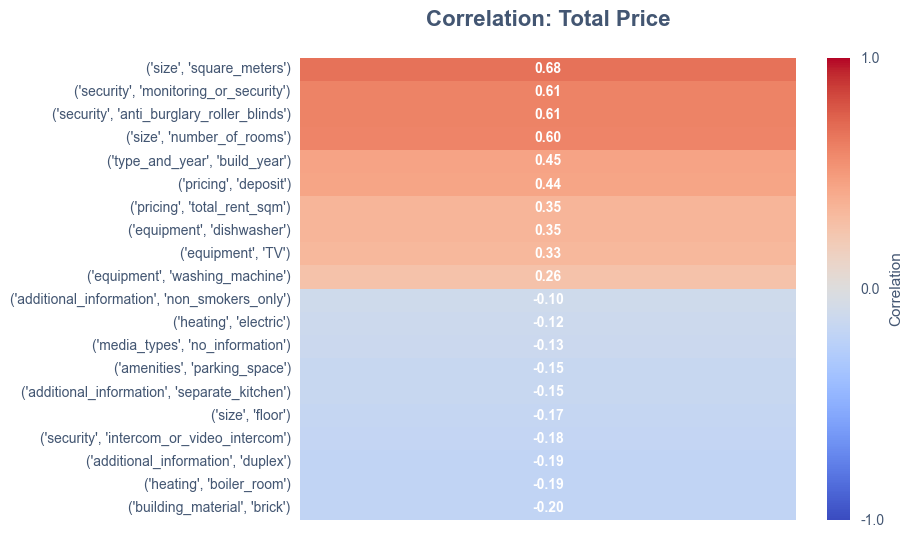

In [65]:
show_extreme_correlations(narrowed_df, ('pricing', 'total_rent'), num_results = 10, title="Total Price")

Other correlations:

In [66]:
print_correlations(narrowed_df)


Strong Correlations:
('size', 'building_floors') - ('type_and_year', 'build_year'): 1.0
('type_and_year', 'build_year') - ('equipment', 'stove'): 1.0
('type_and_year', 'build_year') - ('equipment', 'fridge'): 1.0
('type_and_year', 'build_year') - ('equipment', 'oven'): 1.0
('type_and_year', 'build_year') - ('media_types', 'internet'): 1.0
('type_and_year', 'build_year') - ('media_types', 'cable_TV'): 1.0
('type_and_year', 'build_year') - ('heating', 'district'): 1.0
('type_and_year', 'build_year') - ('security', 'intercom_or_video_intercom'): 1.0
('type_and_year', 'build_year') - ('windows', 'plastic'): 1.0
('type_and_year', 'build_year') - ('additional_information', 'separate_kitchen'): 1.0
('heating', 'boiler_room') - ('additional_information', 'duplex'): 1.0
('security', 'monitoring_or_security') - ('security', 'anti_burglary_roller_blinds'): 1.0
('equipment', 'stove') - ('equipment', 'fridge'): 0.95
('equipment', 'stove') - ('equipment', 'oven'): 0.91
('media_types', 'internet') -

### 2.4 Attributes and equipment

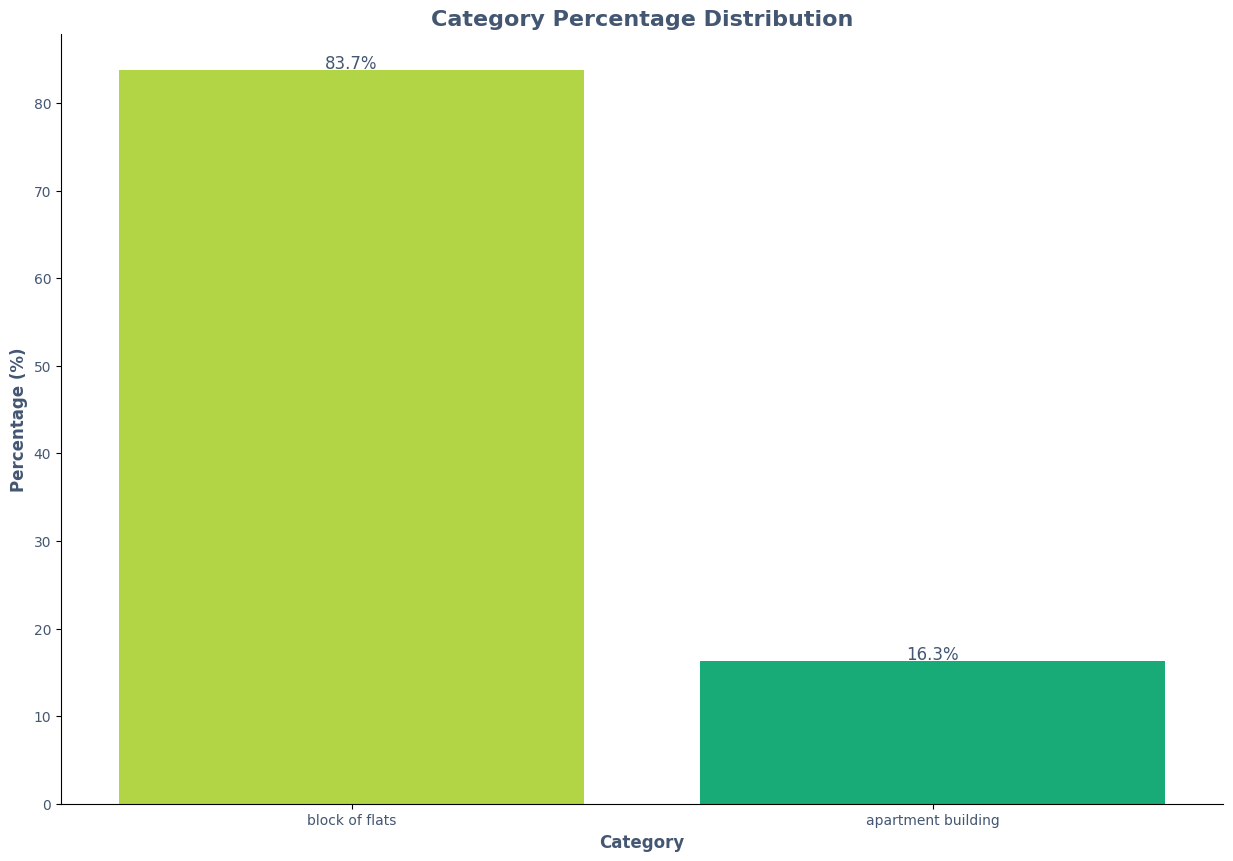

In [67]:
def display_category_proportions(data: pd.Series, title: str):
    # Check if data is a Series and of string type
    if not isinstance(data, pd.Series) or data.dtype != 'string[python]':
        raise TypeError("Data must be a pandas Series with string type.")

    # Calculate the percentage of each category
    category_percentage = data.value_counts(normalize=True) * 100

    # Create a bar plot
    fig, ax = plt.subplots(figsize=aesthetics_plots["figsize"]["multiplot"])
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"] + ['#51006f']*2

    unique_categories = data.unique()
    length = len(unique_categories)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    # Make the index more readable
    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', ' '))
    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)


    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()


display_category_proportions(narrowed_df[('type_and_year', 'building_type')], "Category Percentage Distribution")

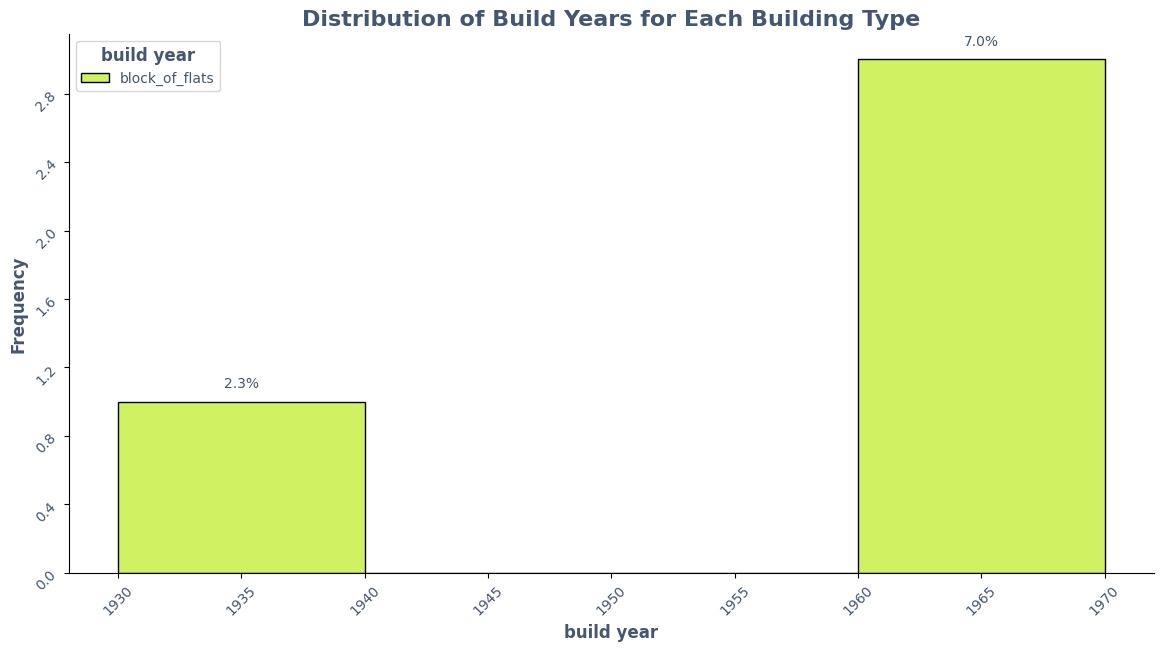

In [68]:
show_categorical_data_percentage_distribution(
    narrowed_df,  
    ('type_and_year', 'building_type'),
    ('type_and_year', 'build_year'),
    'Distribution of Build Years for Each Building Type'
    )

In [69]:
def move_index_to_last(series, index_to_move):
    """
    Moves a specified index to the last position in a pandas Series.

    Args:
    series (pd.Series): The original series.
    index_to_move (str): The index to be moved to the last position.

    Returns:
    pd.Series: A new series with the specified index moved to the last position.
    """
    if index_to_move not in series.index:
        raise ValueError(f"Index '{index_to_move}' not found in the Series.")

    # Extracting the indices
    idx_list = series.index.tolist()

    # Remove the index to move and then append it at the end
    idx_list.remove(index_to_move)
    idx_list.append(index_to_move)

    # Reindexing the series
    return series.reindex(idx_list)

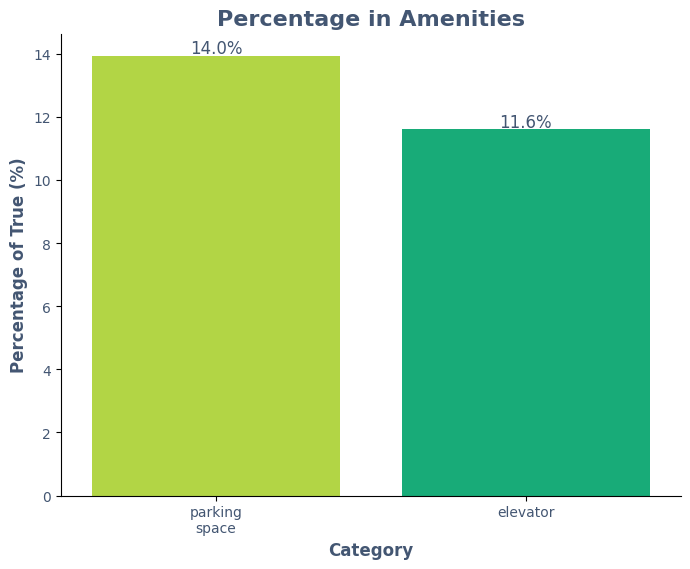

In [70]:
def visualize_true_percentage_by_category(df: pd.DataFrame, main_category: str):
    # Check if the DataFrame contains the main category
    if main_category not in df.columns.get_level_values(0):
        raise KeyError(f"Main category '{main_category}' not found in DataFrame.")

    # Extract subcategories for the given main category
    subcategories = [col for col in df.columns if col[0] == main_category]

    # Calculate percentage of True values for each subcategory
    percentages = {}
    for subcat in subcategories:
        percentages[subcat[1]] = (df[subcat].sum() / len(df)) * 100

    # Convert to Series for plotting
    category_percentage = pd.Series(percentages)

    # Sort by percentage, 'no_information' should be last
    category_percentage = category_percentage.sort_values(ascending=False)
    if 'no_information' in category_percentage.index:
        category_percentage = move_index_to_last(category_percentage, 'no_information')

    # Create a bar plot
    if category_percentage.index.__len__() >= 5:
        plot_size = aesthetics_plots["figsize"]["multiplot"]
    else:
        plot_size = aesthetics_plots["figsize"]["singleplot"]

    fig, ax = plt.subplots(figsize=plot_size)

    # Set the palette
    length = len(category_percentage.index)
    if (length - 5) <= 0:
        adjusted_length = 1
    else:
        adjusted_length = length - 5
    my_palette = ['#bfed2d'] + ['#00c37f'] + ["#007e90"]*2 + ['#51006f']*adjusted_length

    if 'no_information' in category_percentage.index:
        my_palette = my_palette[:max(1, length - 1)] + ['#b3b3b3']

    more_readable_index = []
    for _index in category_percentage.index:
        more_readable_index.append(_index.replace('_', '\n'))

    category_percentage.index = more_readable_index

    sns.barplot(x=category_percentage.index, y=category_percentage.values, ax=ax, palette=my_palette)
    
    # Add labels to the plot
    title = "Percentage in " + main_category.replace('_', ' ').title()
    plt.title(title, color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['title_size'], weight=aesthetics_plots['fontweight'])
    plt.xlabel('Category', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])
    plt.ylabel('Percentage of True (%)', color=aesthetics_plots['label_color'], fontsize=aesthetics_plots['y_and_x_label_size'], weight=aesthetics_plots['fontweight'])

    plt.xticks(color=aesthetics_plots['label_color'])
    plt.yticks(color=aesthetics_plots['label_color'])
    
    sns.despine(right=True, top=True)

    # Add percentage labels on the bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color=aesthetics_plots['label_color'], xytext=(0, 5),
                    textcoords='offset points')

    # Display the plot
    plt.show()

visualize_true_percentage_by_category(narrowed_df, 'amenities')

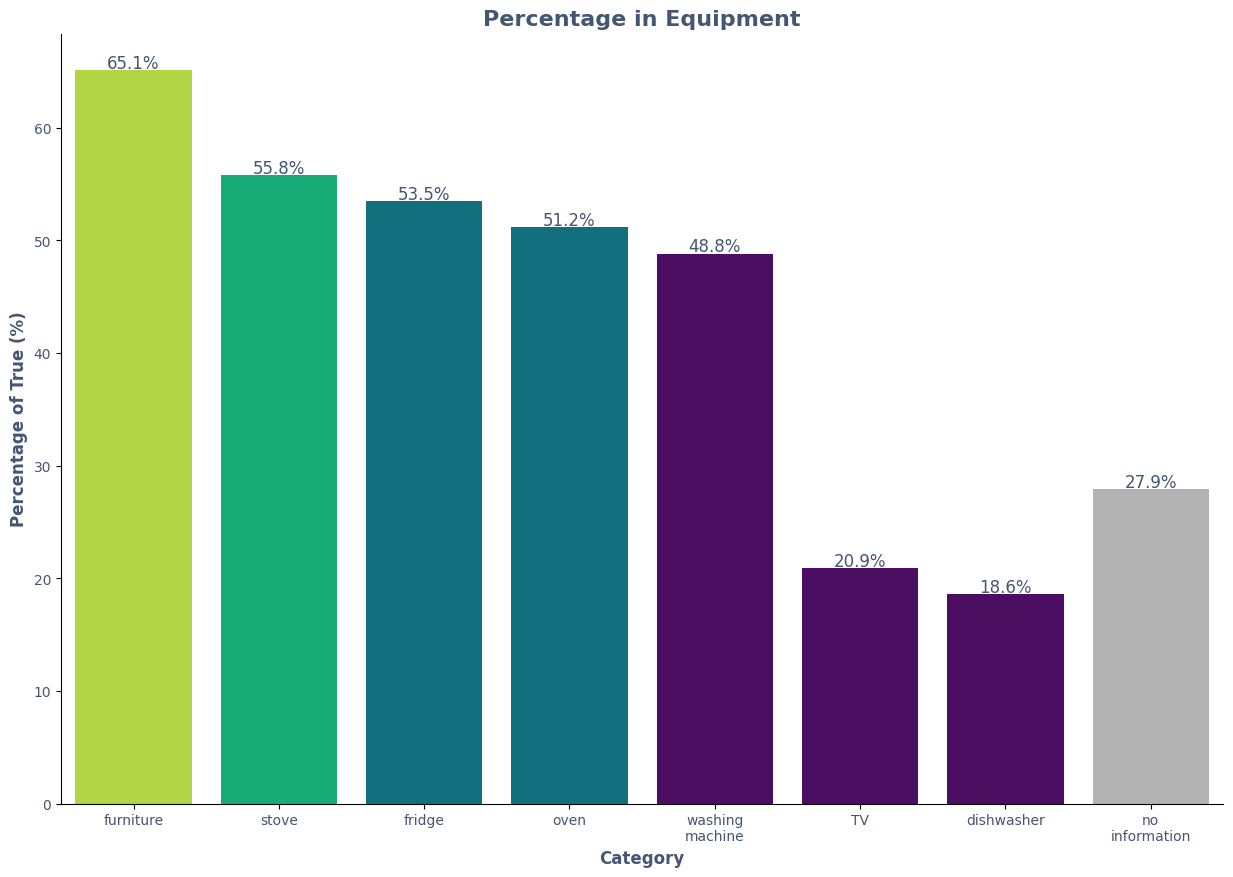

In [71]:
visualize_true_percentage_by_category(narrowed_df, 'equipment')

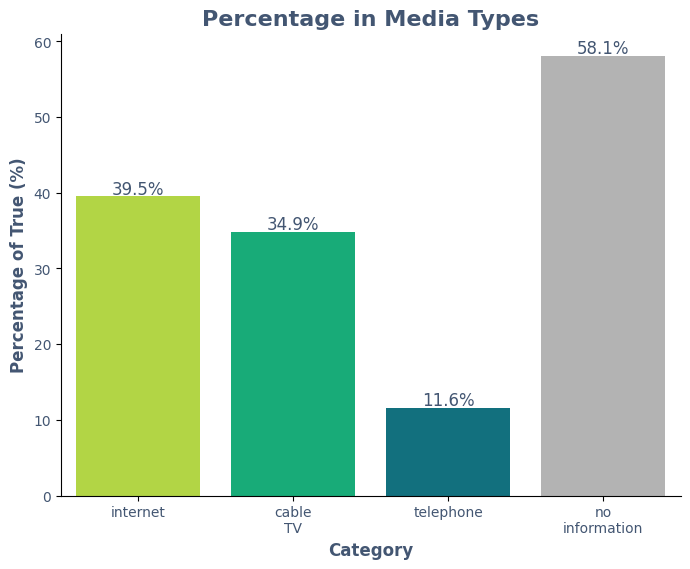

In [72]:
visualize_true_percentage_by_category(narrowed_df, 'media_types')

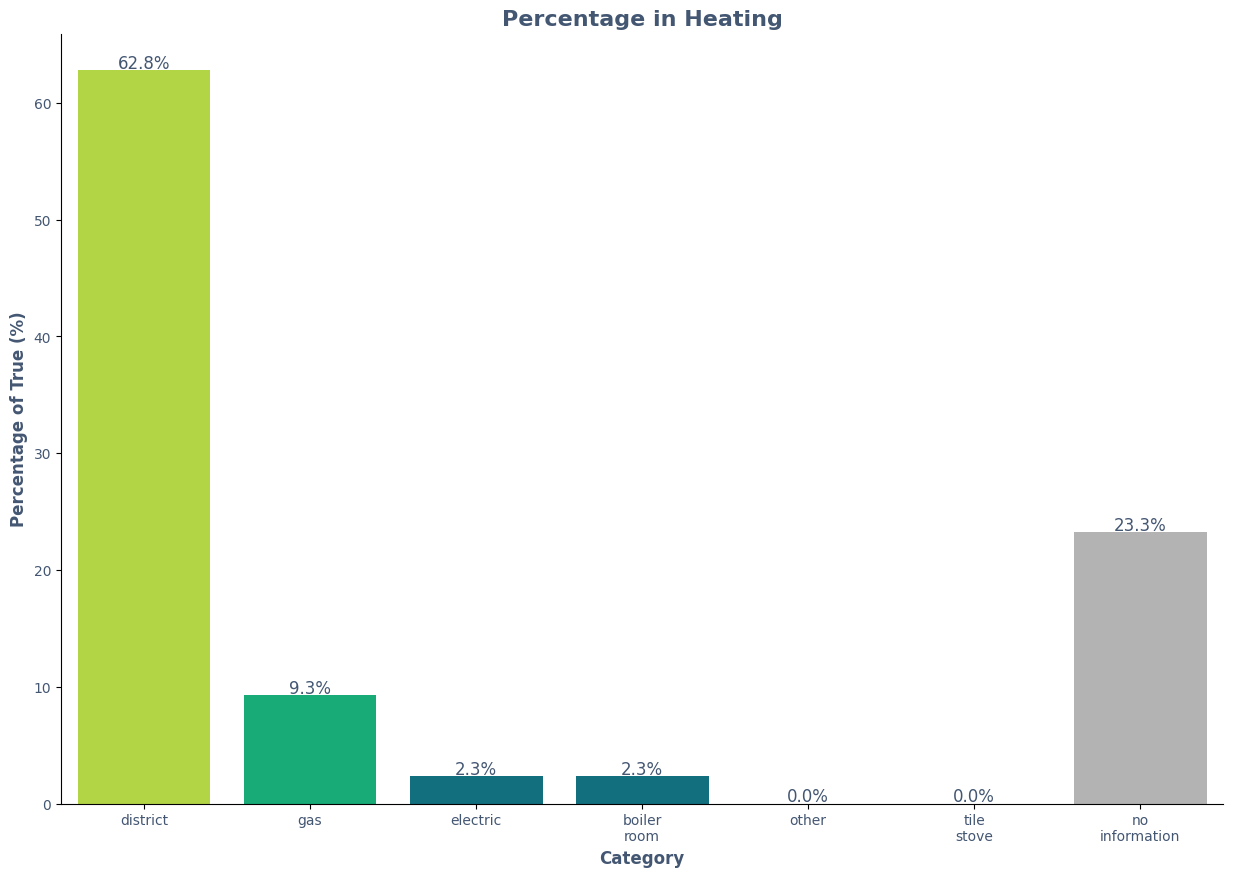

In [73]:
visualize_true_percentage_by_category(narrowed_df, 'heating')

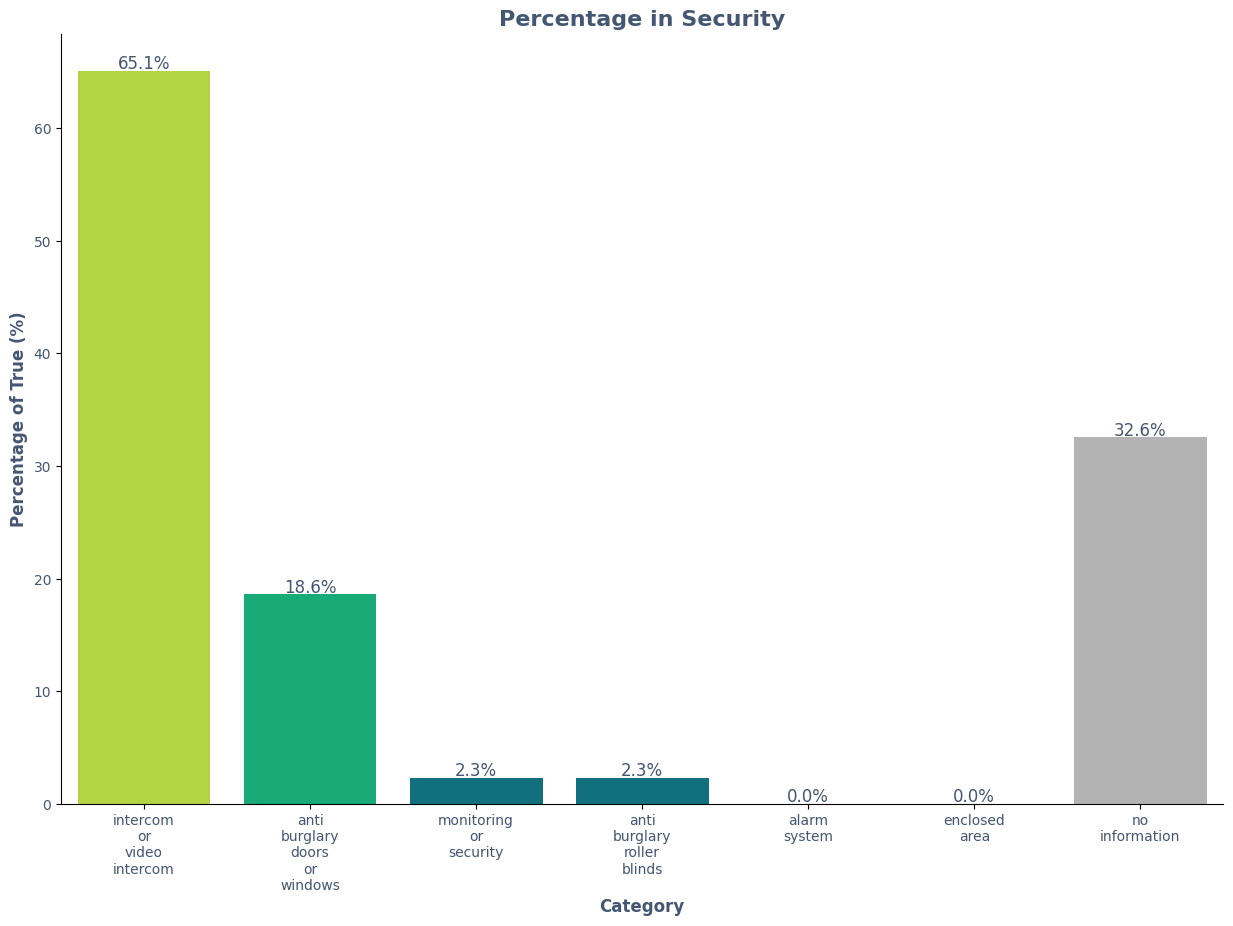

In [74]:
visualize_true_percentage_by_category(narrowed_df, 'security')

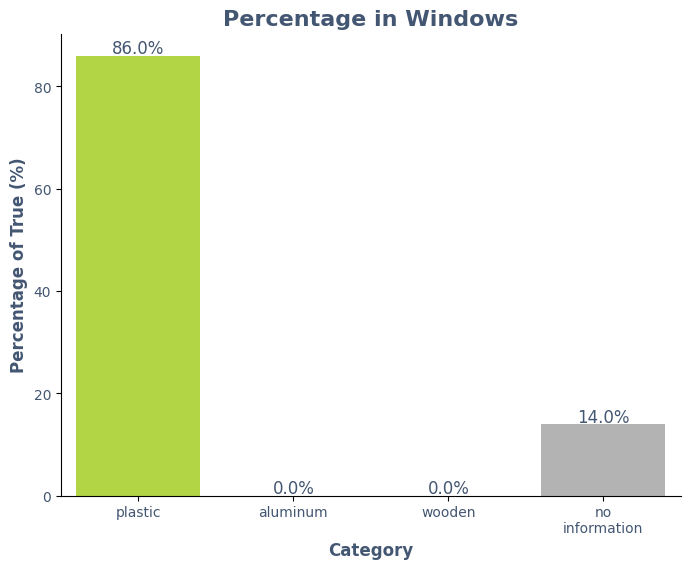

In [75]:
visualize_true_percentage_by_category(narrowed_df, 'windows')

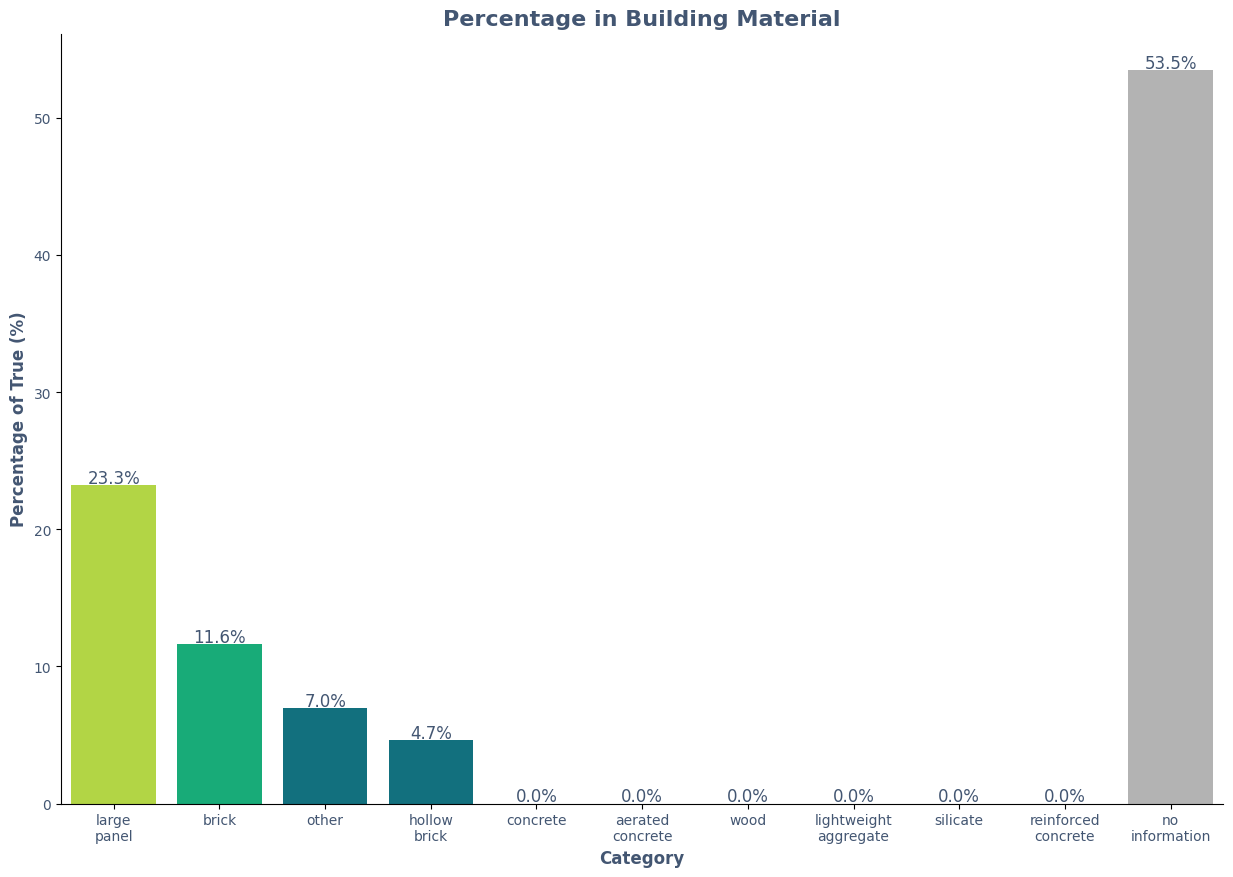

In [76]:
visualize_true_percentage_by_category(narrowed_df, 'building_material')

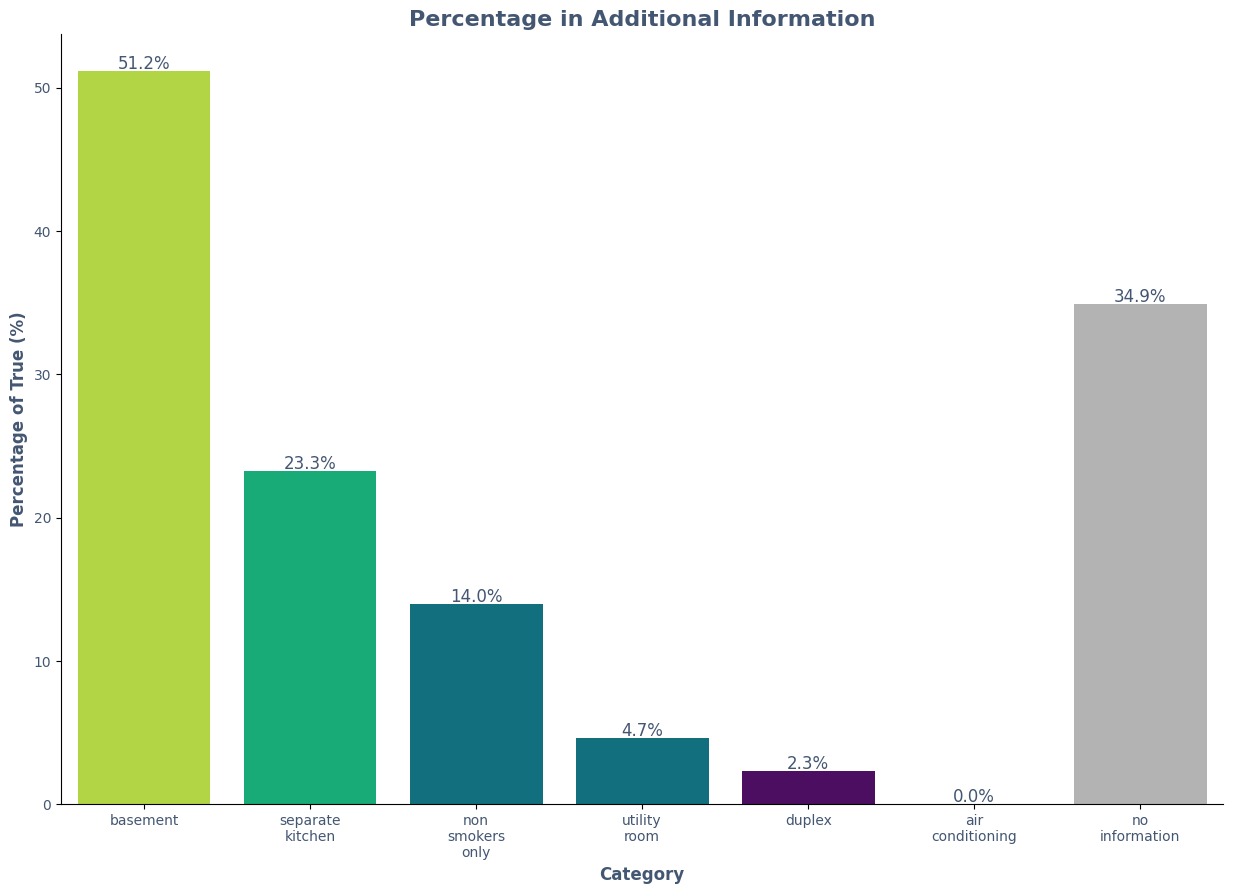

In [77]:
visualize_true_percentage_by_category(narrowed_df, 'additional_information')